<a href="https://colab.research.google.com/github/RajaniBoddupally/0901_Project_CarPricePrediction/blob/main/0901_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code to Import the libraries that are required for this project
import os
import warnings
warnings.simplefilter(action='ignore')
import re
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Functions

In [ ]:
def Fetch_Only_Numbers(coldata):
    """
    Extracts the numbers from input.

    Parameters:
    value (str or any): The input value which can be a string or any other type.

    Returns:
    str or any: If the input is a string with numbers, the first numeric value is returned.
                If no numeric value is found in the string, `None` is returned.
                If the input is not a string, the input value is returned unchanged.
    """

    if isinstance(coldata, str):
        Number_found = re.findall(r"[-+]?\d*\.\d+|\d+", coldata)
        return Number_found[0] if Number_found else None
    return coldata


### Data Loading

In [ ]:
# Code to read the csv from github
Cardetails_File = 'https://raw.githubusercontent.com/RajaniBoddupally/0901_Project_CarPricePrediction/refs/heads/main/Car%20details%20v3.csv'
Car_Details_Data = pd.read_csv(Cardetails_File)
# Printing the first 5 rows of the data
print(Car_Details_Data.head())

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

In [ ]:
# Print the shape of the dataset(Rows and Columns)
print(f'Shape of the Dataset before pre-processing:{Car_Details_Data.shape}')

Shape of the Dataset before pre-processing:(8128, 13)


In [ ]:
# Checking for null values in the dataset
Car_Details_Data.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [ ]:
# Checking the data type of each column
Car_Details_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


### Data Pre-Processing

In [ ]:
# Code to extract the numbers from the columns which have text in them
Car_Details_Data['mileage'] = Car_Details_Data['mileage'].apply(Fetch_Only_Numbers)
Car_Details_Data['engine'] = Car_Details_Data['engine'].apply(Fetch_Only_Numbers)
Car_Details_Data['max_power'] = Car_Details_Data['max_power'].apply(Fetch_Only_Numbers)
Car_Details_Data['torque'] = Car_Details_Data['torque'].apply(lambda x: re.findall(r"[-+]?\d*\.\d+|\d+", x)[0] if isinstance(x, str) and re.findall(r"[-+]?\d*\.\d+|\d+", x) else None)

#Appending the Modified data to the columns
Car_Details_Data[['mileage', 'engine', 'max_power', 'torque']] = Car_Details_Data[['mileage', 'engine', 'max_power', 'torque']].astype(float, errors='ignore')

#Printing the details after Modification
print(Car_Details_Data)


                              name  year  selling_price  km_driven    fuel  \
0           Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1     Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2         Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3        Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4           Maruti Swift VXI BSIII  2007         130000     120000  Petrol   
...                            ...   ...            ...        ...     ...   
8123             Hyundai i20 Magna  2013         320000     110000  Petrol   
8124         Hyundai Verna CRDi SX  2007         135000     119000  Diesel   
8125        Maruti Swift Dzire ZDi  2009         382000     120000  Diesel   
8126               Tata Indigo CR4  2013         290000      25000  Diesel   
8127               Tata Indigo CR4  2013         290000      25000  Diesel   

     seller_type transmission                 owner  mileage  e

In [ ]:
#Filling the missing values using Clustering technique
missval_impute_KNN = KNNImputer(n_neighbors=5)
Car_Details_Data[['mileage', 'engine', 'max_power', 'torque', 'seats']] = missval_impute_KNN.fit_transform(Car_Details_Data[['mileage', 'engine', 'max_power', 'torque', 'seats']])


In [ ]:
# Checking if the null values are filled or not
Car_Details_Data.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,0
engine,0


In [ ]:
# Code to Check for duplicates
DupCheck_Cardet = Car_Details_Data.duplicated()

# printing the number of duplicate rows
Cnt_Car_Duplicates = DupCheck_Cardet.sum()
print(f'Number of duplicates found : {Cnt_Car_Duplicates}')

Number of duplicates found : 1202


In [ ]:
# Code to Remove duplicate rows
CarData_Post_Prepro = Car_Details_Data.drop_duplicates()

# Confirming the removal by checking the number of duplicates again
Cnt_Dup_Removal = CarData_Post_Prepro.duplicated().sum()
print(f'Number of duplicate rows after removal: {Cnt_Dup_Removal}')

Number of duplicate rows after removal: 0


In [ ]:
# Encoding the categorcal variables
catvar_labenc = LabelEncoder()
CarData_Post_Prepro['fuel'] = catvar_labenc.fit_transform(CarData_Post_Prepro['fuel'])
CarData_Post_Prepro['seller_type'] = catvar_labenc.fit_transform(CarData_Post_Prepro['seller_type'])
CarData_Post_Prepro['transmission'] = catvar_labenc.fit_transform(CarData_Post_Prepro['transmission'])
CarData_Post_Prepro['owner'] = catvar_labenc.fit_transform(CarData_Post_Prepro['owner'])

In [ ]:
# Checking if the variables are converted from object to int
CarData_Post_Prepro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6926 entries, 0 to 8125
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   year           6926 non-null   int64  
 2   selling_price  6926 non-null   int64  
 3   km_driven      6926 non-null   int64  
 4   fuel           6926 non-null   int64  
 5   seller_type    6926 non-null   int64  
 6   transmission   6926 non-null   int64  
 7   owner          6926 non-null   int64  
 8   mileage        6926 non-null   float64
 9   engine         6926 non-null   float64
 10  max_power      6926 non-null   float64
 11  torque         6926 non-null   float64
 12  seats          6926 non-null   float64
dtypes: float64(5), int64(7), object(1)
memory usage: 757.5+ KB


In [ ]:
# Calculating age of the car based on year it was bought
CarData_Post_Prepro['Age'] = 2024 - CarData_Post_Prepro['year']
#Removing Year and Name columns from dataset
CarData_Post_Prepro.drop('year',axis=1,inplace = True)
CarData_Post_Prepro.drop('name',axis=1,inplace = True)

In [ ]:
print(f'Shape of the Dataset after pre-processing :{CarData_Post_Prepro.shape}')

Shape of the Dataset after pre-processing :(6926, 12)


In [ ]:
# Check the column names present in dataset after pre-processing
CarData_Post_Prepro.columns

Index(['selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission',
       'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'Age'],
      dtype='object')

In [ ]:
# Printing the first 5 rows after pre-processing
CarData_Post_Prepro.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,Age
0,450000,145500,1,1,1,0,23.40,1248.0,74.00,190.0,5.0,10
1,370000,120000,1,1,1,2,21.14,1498.0,103.52,250.0,5.0,10
2,158000,140000,3,1,1,4,17.70,1497.0,78.00,12.7,5.0,18
3,225000,127000,1,1,1,0,23.00,1396.0,90.00,22.4,5.0,14
4,130000,120000,3,1,1,0,16.10,1298.0,88.20,11.5,5.0,17


### Exploratory Data Analysis [EDA]

#### Bar Plot Visualization

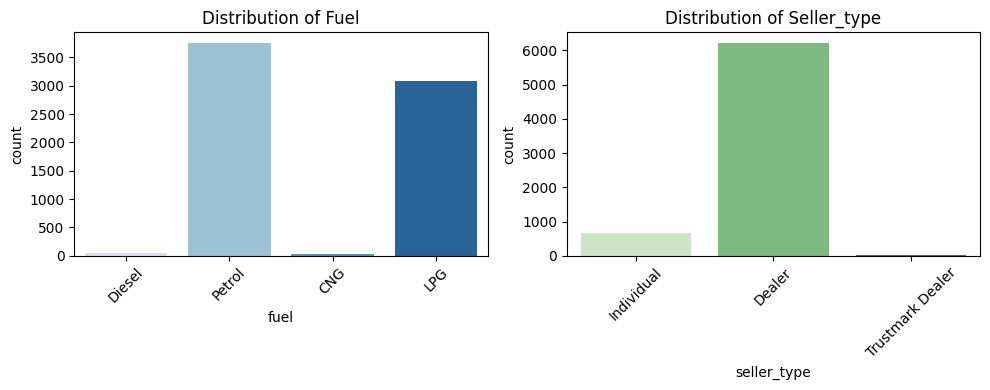

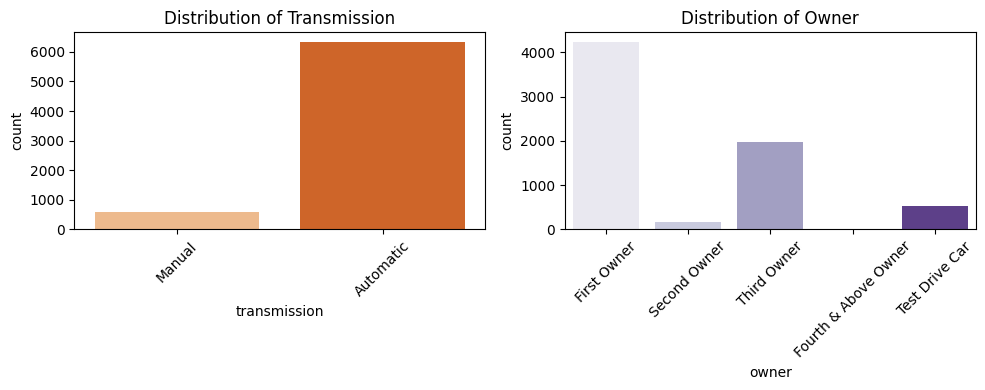

In [ ]:
# Code to visualize the Distribution of categorical variables through Bar plots
# declaring the list of categorical columns for Plots
CarData_Catcol = ['fuel', 'seller_type', 'transmission', 'owner']

# mapping values for each categorical column
ValuesMap_catvar= {
    'fuel': ['Diesel', 'Petrol', 'CNG', 'LPG'],
    'seller_type': ['Individual', 'Dealer', 'Trustmark Dealer'],
    'transmission': ['Manual', 'Automatic'],
    'owner': ['First Owner', 'Second Owner', 'Third Owner',
              'Fourth & Above Owner', 'Test Drive Car']
}

# Defining colors for visualizing each column
color_catvar = {
    'fuel': 'Blues',
    'seller_type': 'Greens',
    'transmission': 'Oranges',
    'owner': 'Purples'
}

# Initialize the loop variable
i = 0

# Loop to create visualizations for the categorical columns
while i < 4:
    # Create a new figure
    fig = plt.figure(figsize=[10, 4])

    # Distribution of the Fuel Distribution
    plt.subplot(1, 2, 1)
    sns.countplot(
        x=CarData_Catcol[i],
        data=CarData_Post_Prepro,
        palette=color_catvar[CarData_Catcol[i]]
    )
    # Setting the ticks for x-axis
    plt.xticks(
        ticks=range(len(ValuesMap_catvar[CarData_Catcol[i]])),
        labels=ValuesMap_catvar[CarData_Catcol[i]],
        rotation=45
    )
     # Adding Title for the plot
    plt.title(f"Distribution of {CarData_Catcol[i].capitalize()}")
    i += 1

    # Distribution of the Seller type Distribution
    plt.subplot(1, 2, 2)
    sns.countplot(
        x=CarData_Catcol[i],
        data=CarData_Post_Prepro,
        palette=color_catvar[CarData_Catcol[i]]
    )
     # Setting the ticks for x-axis
    plt.xticks(
        ticks=range(len(ValuesMap_catvar[CarData_Catcol[i]])),
        labels=ValuesMap_catvar[CarData_Catcol[i]],
        rotation=45
    )
    # Adding Title for the plot
    plt.title(f"Distribution of {CarData_Catcol[i].capitalize()}")
    i += 1

    # Adjusting layout to prevent overlap between subplots
    plt.tight_layout()

    # Showing the combined figure with two plots
    plt.show()


#### Box Plot Visualization

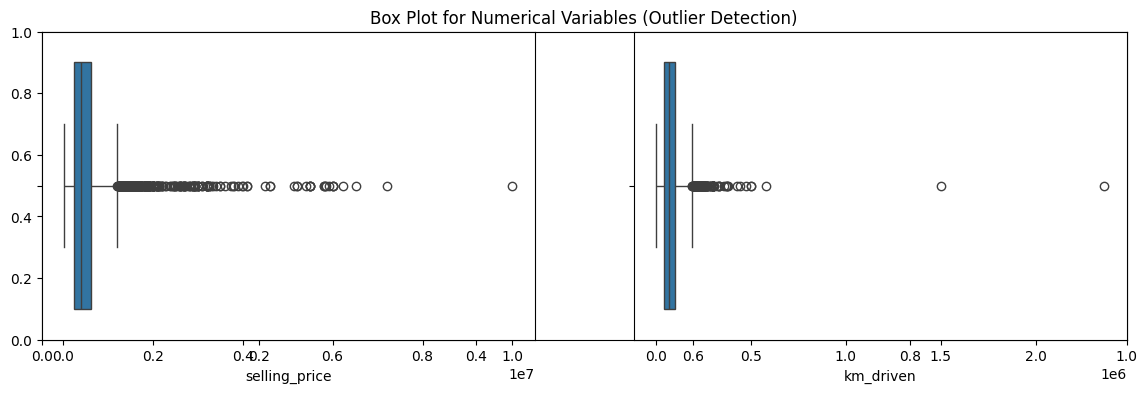

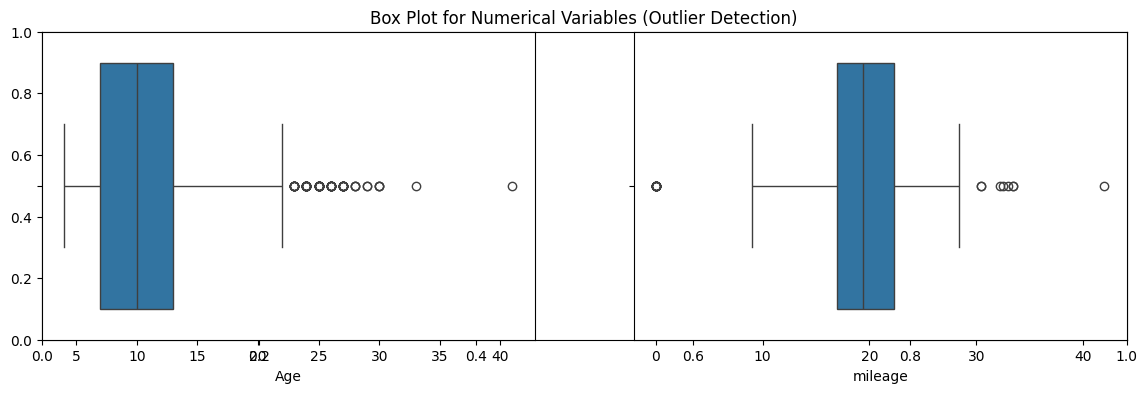

In [ ]:
# Code to display the outliers through box plot visualizations

# Declaring the list of numerical columns
CarData_Numvar = ['selling_price', 'km_driven', 'Age', 'mileage']
i = 0

# Loop through the numerical columns
while i < 4:
    # Create a new figure
    fig = plt.figure(figsize=[14, 4])
    plt.title("Box Plot for Numerical Variables (Outlier Detection)")

    # Creating the box plot for each column
    plt.subplot(1, 2, 1)
    sns.boxplot(
        x=CarData_Numvar[i],
        data=CarData_Post_Prepro
    )
    i += 1
    plt.subplot(1, 2, 2)
    sns.boxplot(
        x=CarData_Numvar[i],
        data=CarData_Post_Prepro
    )
    i += 1

    # Display the combined figure with two boxplots
    plt.show()


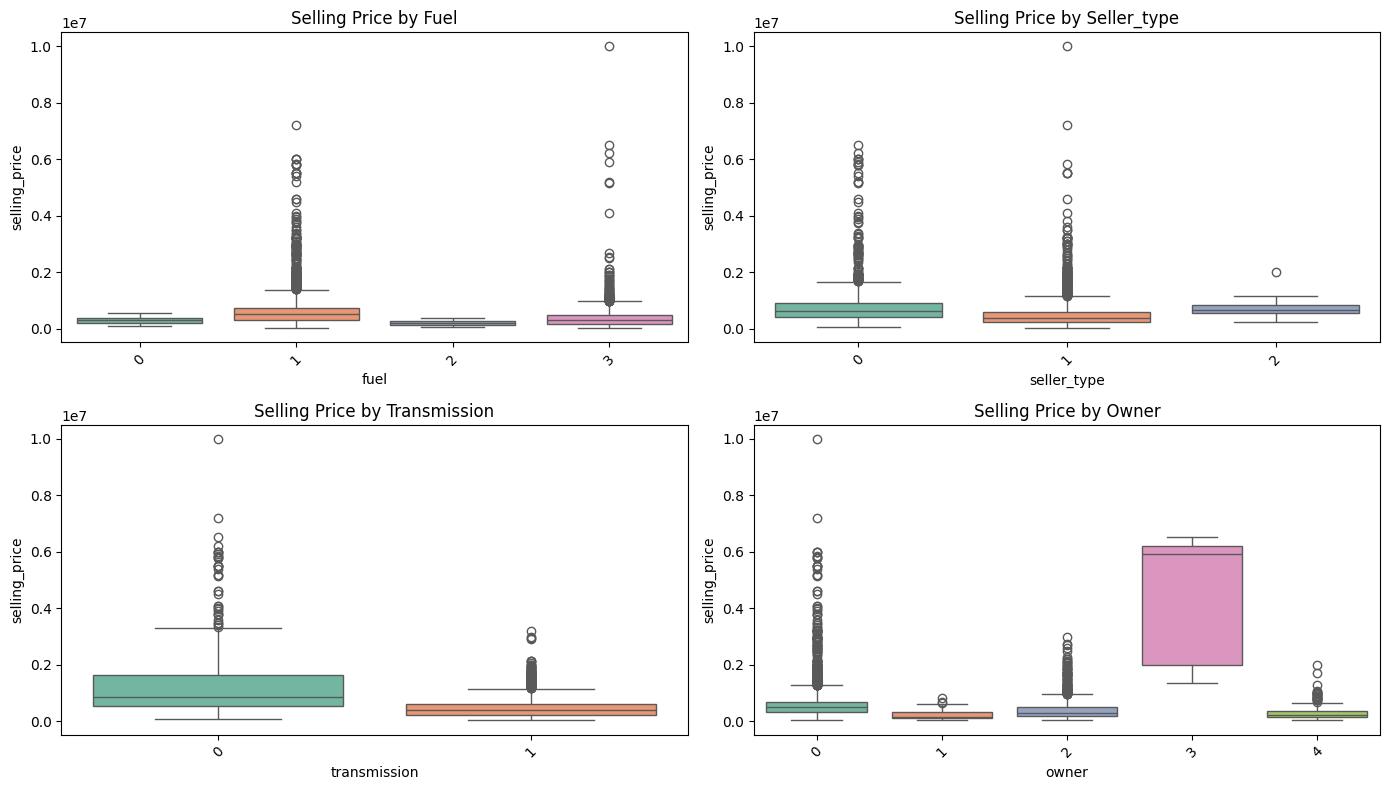

In [ ]:
# Box Plot for Categorical Columns based on Selling price
# Create a New Figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Loop Through Categorical variables and plot the box plots
for i, col in enumerate(CarData_Catcol):
    sns.boxplot(data=CarData_Post_Prepro, x=col, y='selling_price',
                palette="Set2", ax=axes[i])
    # Setting the title for axis and ticks
    axes[i].set_title(f"Selling Price by {col.capitalize()}")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


#### Correlation Heat Map

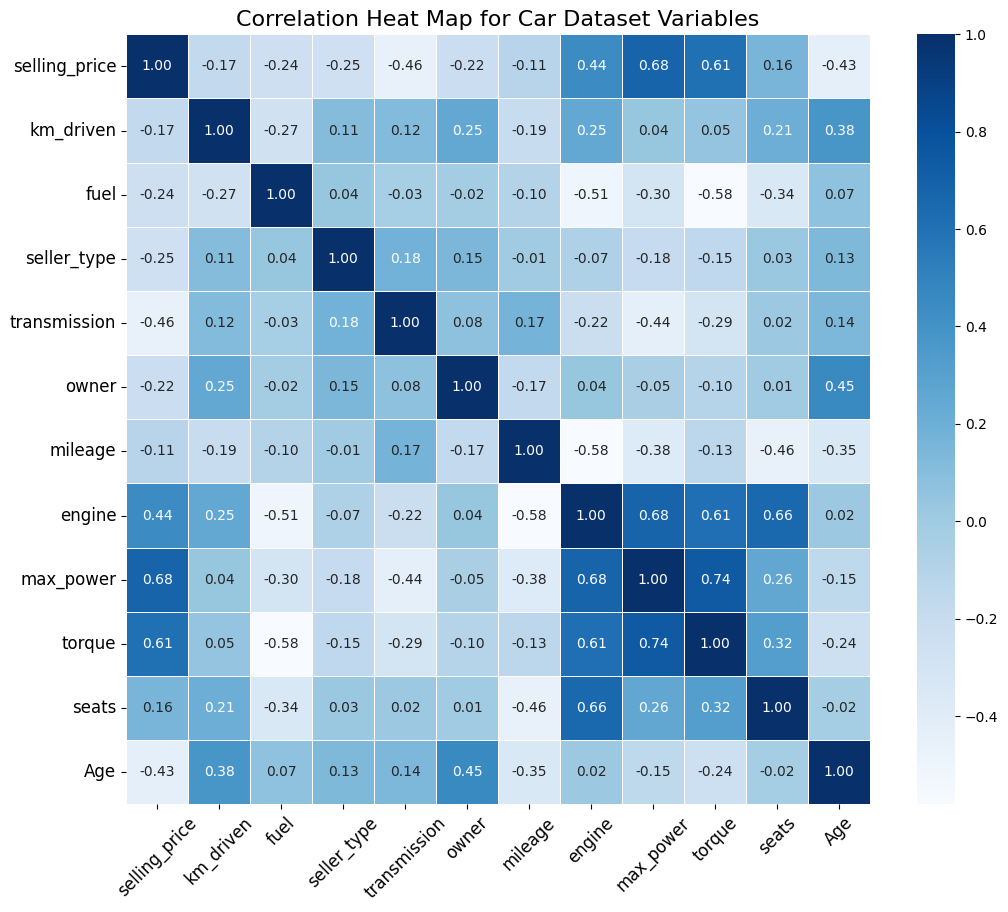

In [ ]:
# Correlation heat map for variables in the dataset
# Calculate the correlation matrix
Corrmat= CarData_Post_Prepro.corr()
# Create a figure
plt.figure(figsize=(12, 10))
# Heat Map using the correlation matrix
sns.heatmap(Corrmat,annot=True,cmap="Blues",fmt=".2f",linewidths=0.5)
plt.title("Correlation Heat Map for Car Dataset Variables", fontsize=16)

#Adding Ticks for X and Y axis
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
# Showing the Heat map for correlation Matrix
plt.show()

In [ ]:
# Relation of Selling Price (Target Variable) with all other variables
CarData_Post_Prepro.corr()['selling_price']

,selling_price
selling_price,1.000000
km_driven,-0.165620
fuel,-0.241328
seller_type,-0.248659
transmission,-0.462683
owner,-0.224121
mileage,-0.107066
engine,0.438371
max_power,0.683904
torque,0.610596


#### Pivot Table

In [ ]:
# Pivot table to see type of car sold by each type of Dealers
fuel_mapping = {0: 'Diesel', 1: 'Petrol', 2: 'CNG', 3: 'LPG'}
seller_Mapping = {0:'Individual',1: 'Dealer',2: 'Trustmark Dealer'}

CarData_Post_Prepro['fuel'] = CarData_Post_Prepro['fuel'].map(fuel_mapping)
CarData_Post_Prepro['seller_type'] = CarData_Post_Prepro['seller_type'].map(seller_Mapping)


CarData_Post_Prepro.pivot_table(
    values='selling_price',
    index='seller_type',
    columns='fuel',
    aggfunc='count')


fuel,CNG,Diesel,LPG,Petrol
seller_type,,,,
Dealer,36.0,56.0,2780.0,3346.0
Individual,2.0,NaN,273.0,406.0
Trustmark Dealer,NaN,NaN,24.0,3.0


#### Histogram Visualization

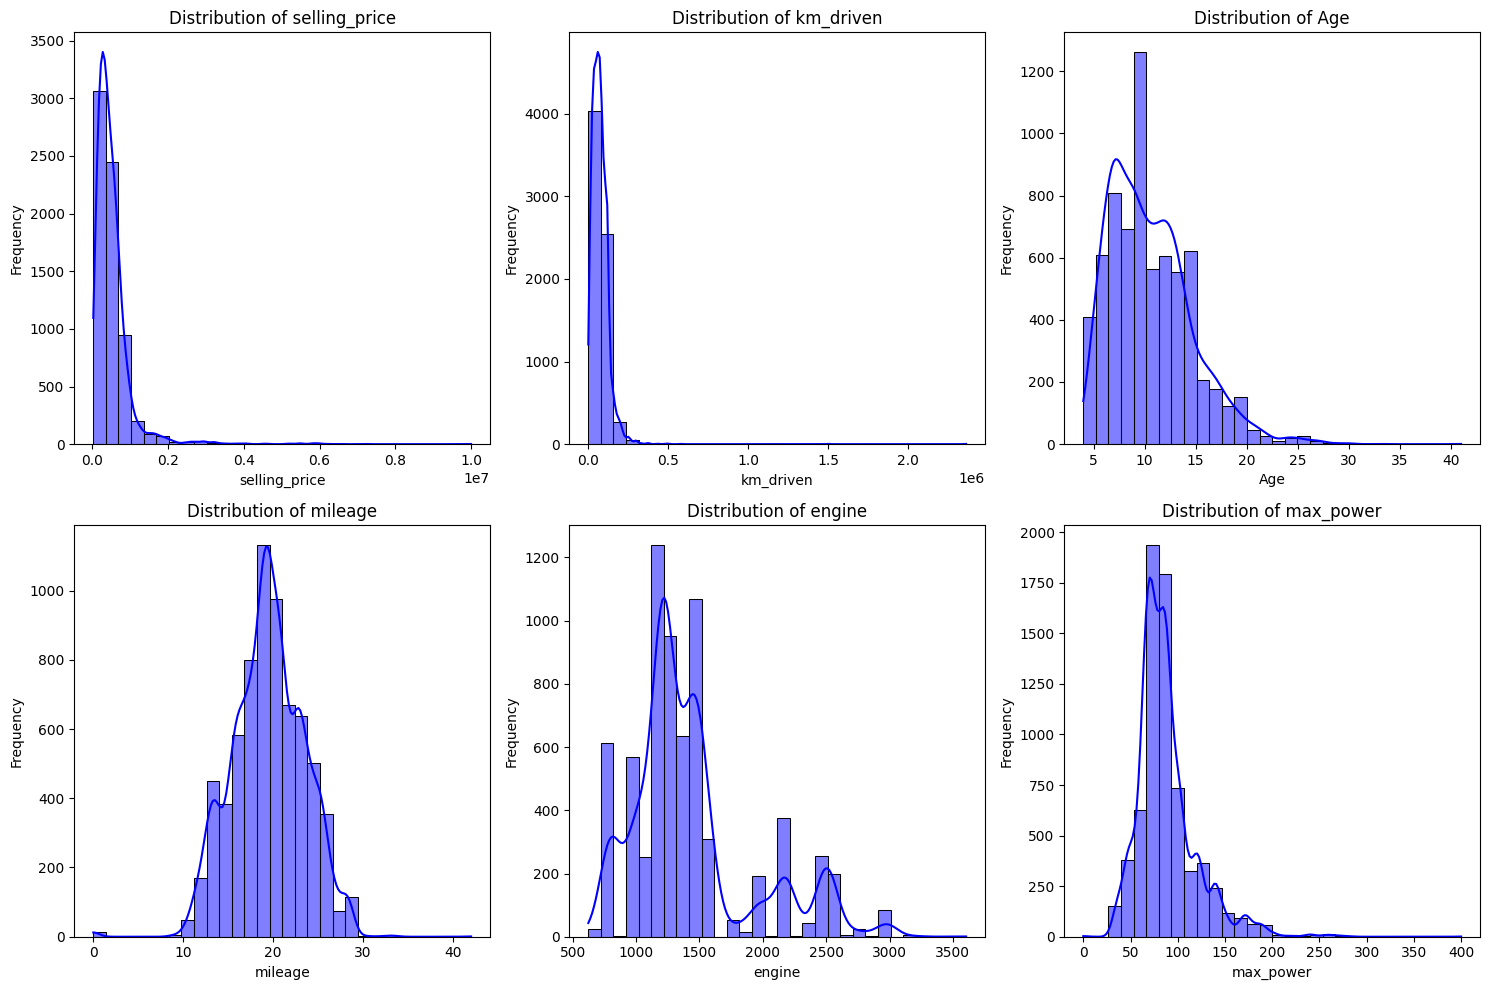

In [ ]:
# Code to Visualiza the distribution of Numerical variables
CarData_Numvars = ['selling_price', 'km_driven', 'Age', 'mileage', 'engine', 'max_power']

#Create a grid of subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Loop through each numerical variable
for i, col in enumerate(CarData_Numvars):
    # Plot a histogram with a kernel density estimate
    sns.histplot(CarData_Post_Prepro[col], kde=True, bins=30, color='blue', ax=axes[i])
    # Set the title for the subplot and axis labels
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Adjust the layout and Display the plot
plt.tight_layout()
plt.show()


#### Relation between Categorical Varibles Through Bar plots

Unique values in fuel:
 fuel
Petrol    3755
LPG       3077
Diesel      56
CNG         38
Name: count, dtype: int64
Unique values in seller_type:
 seller_type
Dealer              6218
Individual           681
Trustmark Dealer      27
Name: count, dtype: int64
Unique values in transmission:
 transmission
1    6342
0     584
Name: count, dtype: int64
Unique values in owner:
 owner
0    4242
2    1974
4     536
1     169
3       5
Name: count, dtype: int64


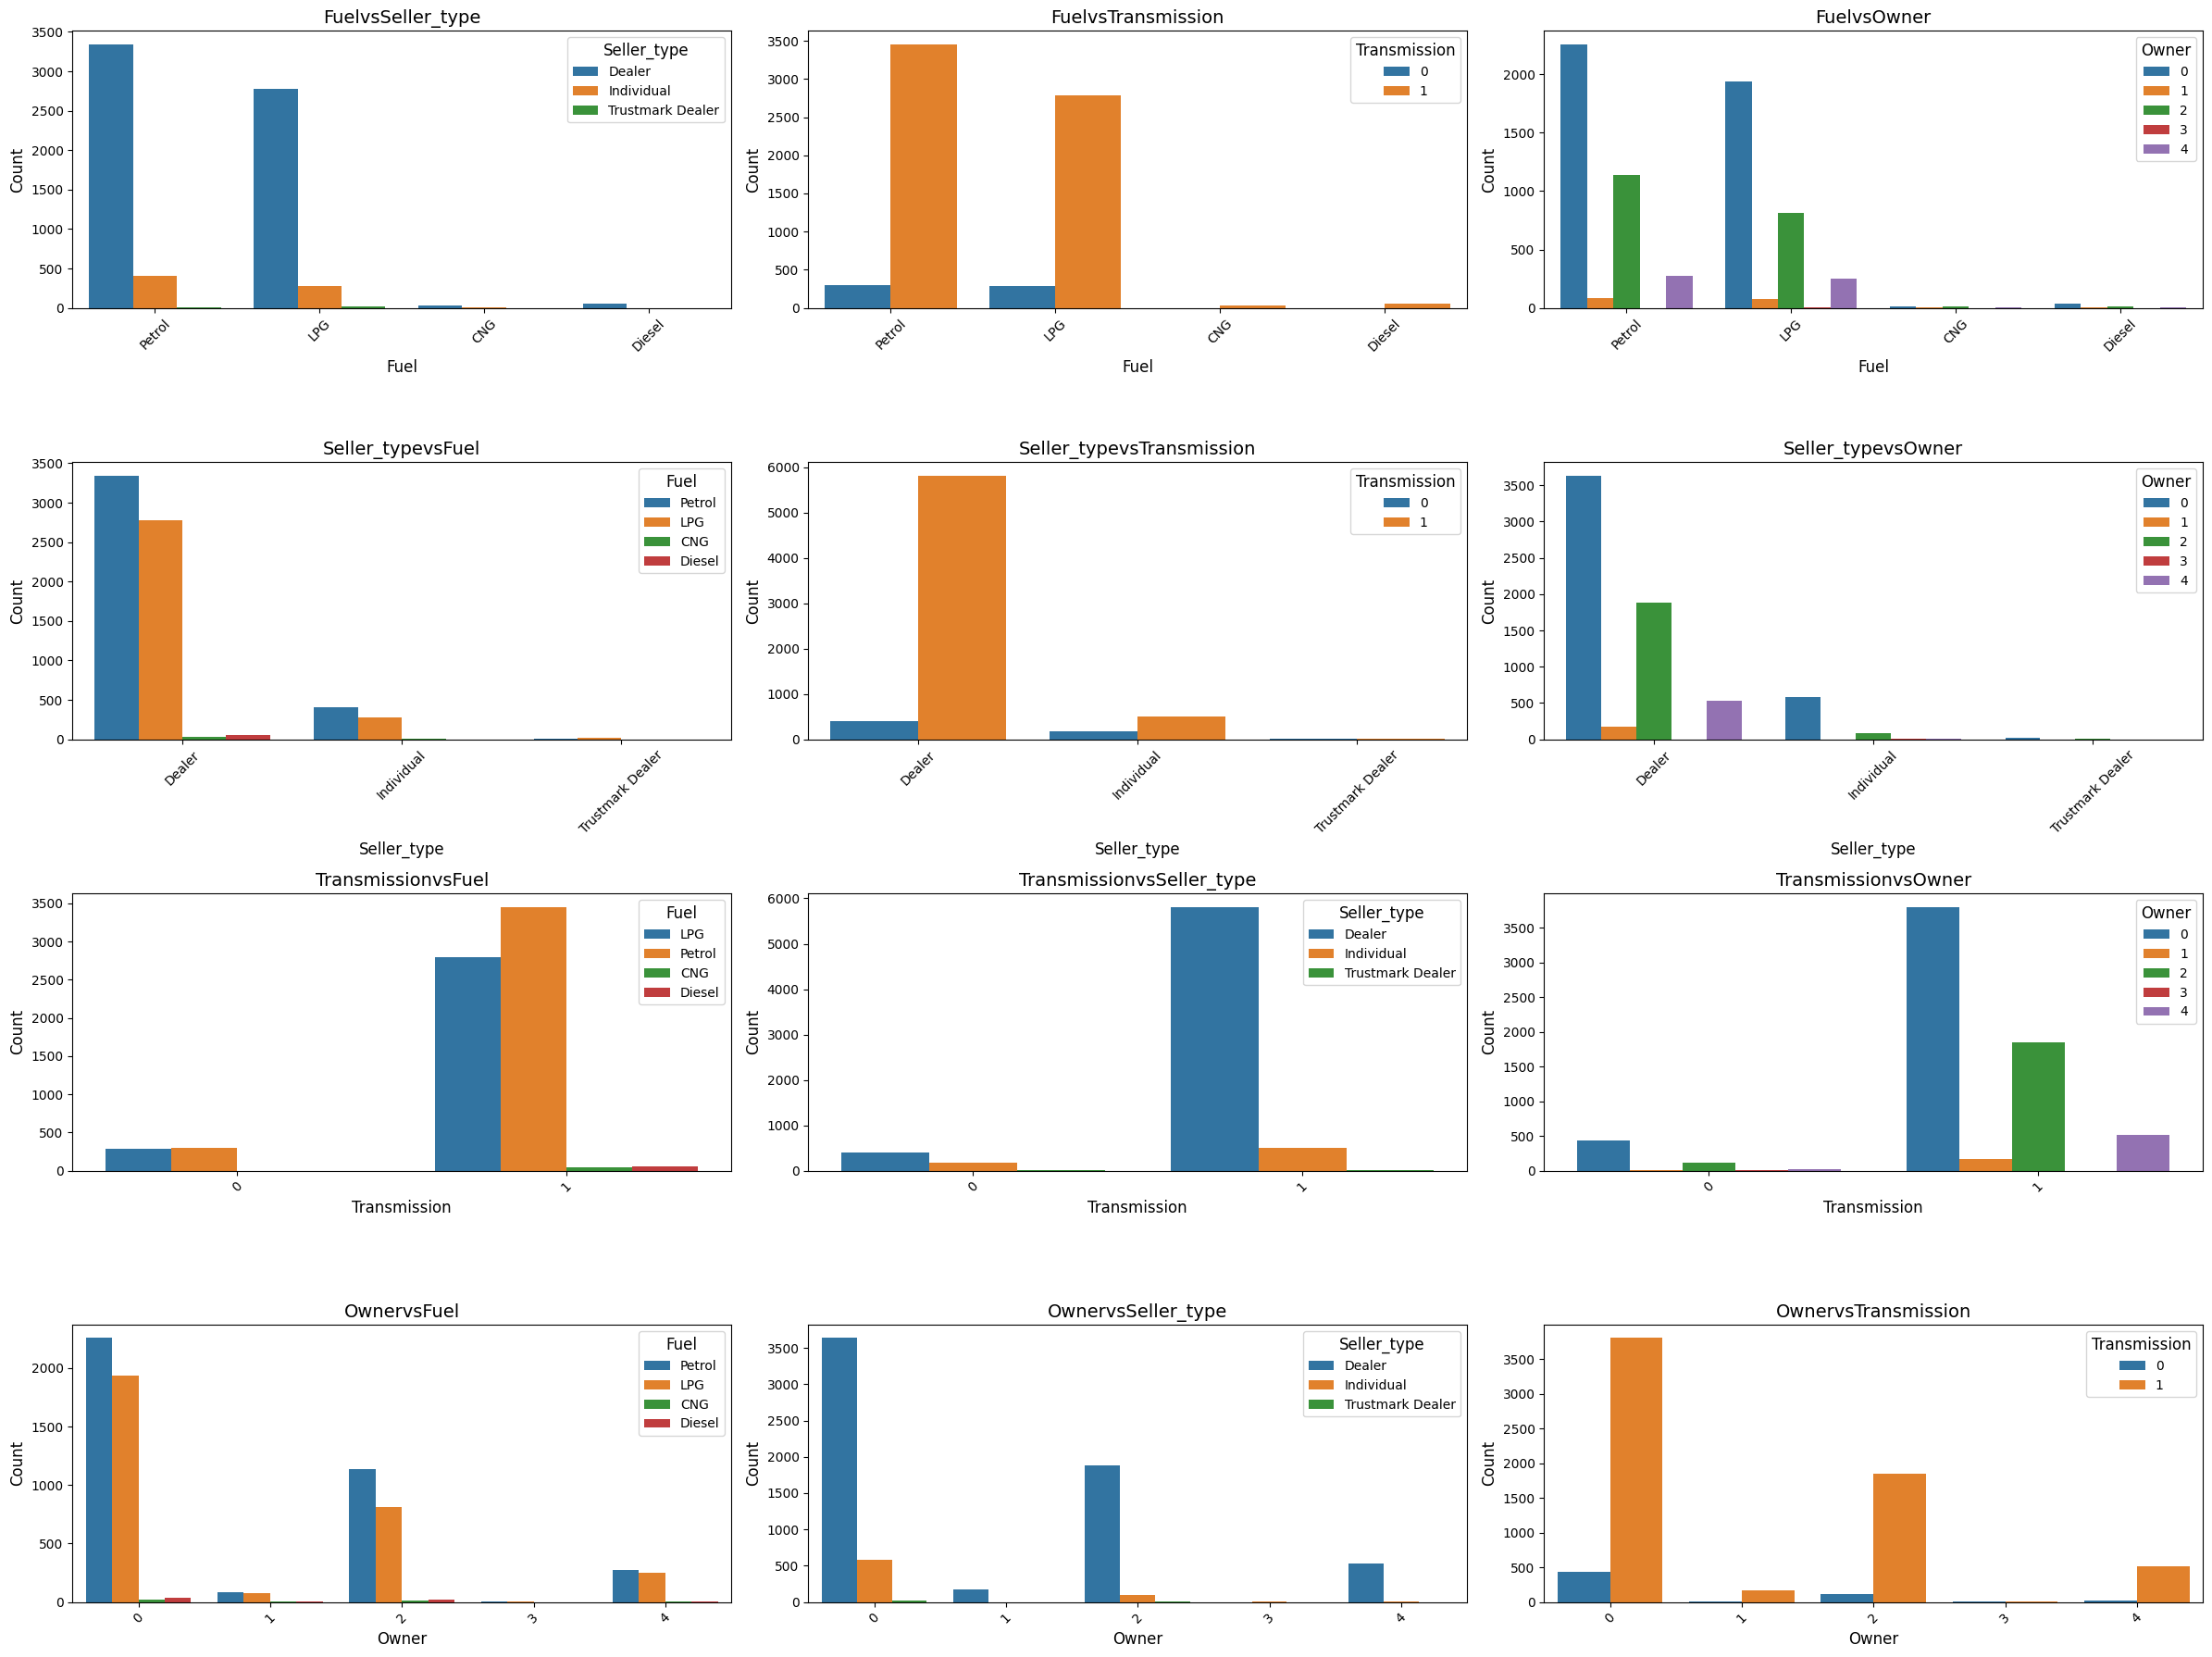

In [ ]:
# Printing the unique value counts for each categorical variable
for cat in CarData_Catcol:
  print(f"Unique values in {cat}:\n", CarData_Post_Prepro[cat].value_counts())

# Calculate the total number of plots required for pairwise combinations
num_plots = len(CarData_Catcol) * (len(CarData_Catcol) - 1)

# Create a grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(24,18))
axes = axes.flatten()
plot_idx = 0

# Generate count plots for every pairwise combination
for cat1 in CarData_Catcol:
    for cat2 in CarData_Catcol:
        if cat1 != cat2:
            # Plotting the count of cat1 with hues representing cat2 categories
            sns.countplot(data=CarData_Post_Prepro, x=cat1, hue=cat2,
                          dodge=True, palette="tab10", ax=axes[plot_idx])
            # Setting the title and axis labels
            axes[plot_idx].set_title(f"{cat1.capitalize()}vs{cat2.capitalize()}"
            , fontsize=14)
            axes[plot_idx].set_xlabel(cat1.capitalize(), fontsize=12)
            axes[plot_idx].set_ylabel("Count", fontsize=12)

            # Rotate x-axis tick labels for better visibility
            axes[plot_idx].tick_params(axis='x', rotation=45)

            # Add legend to the plot
            handles, labels = axes[plot_idx].get_legend_handles_labels()
            if labels:
                axes[plot_idx].legend(title=cat2.capitalize(), fontsize=10,
                                      title_fontsize=12)
            else:
                axes[plot_idx].legend([], [], frameon=False)
            plot_idx += 1

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


#### Line Plot

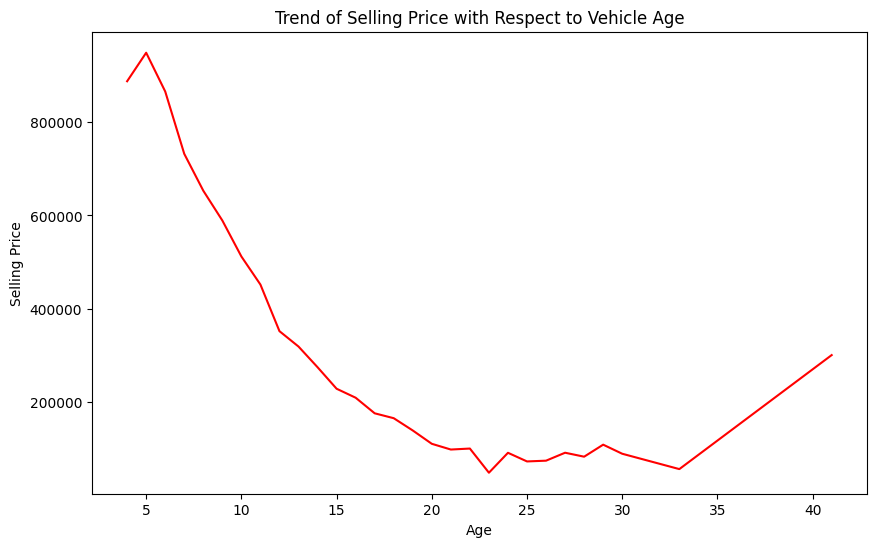

In [ ]:
#Plotting Relationship Between Car Age and Selling Price through Line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=CarData_Post_Prepro, x='Age', y='selling_price',
             color='red', ci=None)
# Setting the Plot title and Axis Labels
plt.title("Trend of Selling Price with Respect to Vehicle Age")
plt.xlabel("Age")
plt.ylabel("Selling Price")
plt.show()


In [ ]:
# Encoding the categorcal variables
catvar_labenc = LabelEncoder()
CarData_Post_Prepro['fuel'] = catvar_labenc.fit_transform(CarData_Post_Prepro['fuel'])
CarData_Post_Prepro['seller_type'] = catvar_labenc.fit_transform(CarData_Post_Prepro['seller_type'])
CarData_Post_Prepro['transmission'] = catvar_labenc.fit_transform(CarData_Post_Prepro['transmission'])
CarData_Post_Prepro['owner'] = catvar_labenc.fit_transform(CarData_Post_Prepro['owner'])

### Data Splitting

In [ ]:
#Declaring Target and Predictor Variables
CarData_Tgt = CarData_Post_Prepro['selling_price']
CarData_Pred = CarData_Post_Prepro.drop('selling_price',axis=1)
#Splitting the dataset into training and testing sets
CarData_Pred_train, CarData_Pred_test, CarData_Tgt_train,CarData_Tgt_test = train_test_split(CarData_Pred, CarData_Tgt,
                                    test_size=0.2, random_state=901)
#Printing the shape of training and testing datasets
print("Shape of predictors in the training set: ",CarData_Pred_train.shape)
print("Shape of predictors in the Testing set: ",CarData_Pred_test.shape)
print("Shape of target variable in the training set: ",CarData_Tgt_train.shape)
print("Shape of target variable in the Testing set: ",CarData_Tgt_test.shape)

Shape of predictors in the training set:  (5540, 11)
Shape of predictors in the Testing set:  (1386, 11)
Shape of target variable in the training set:  (5540,)
Shape of target variable in the Testing set:  (1386,)


In [ ]:
# Declaring dictionaries to store values
Cross_Val = []
R_Sqr_train = []
R_Sqr_test = []

def CarData_Model_All(reg_model, reg_model_name):
    """
    Train and evaluate a regression model, compute R2 scores,
    perform cross-validation,
    and visualize results using residual and scatter plots.

    Parameters:
    - reg_model: The regression model to be trained and evaluated
    - reg_model_name: A string representing the name of the model

    Global Variables Used:
    - CarData_Pred_train: Predictor variables for training the model.
    - CarData_Tgt_train: Target variable for training the model.
    - CarData_Pred_test: Predictor variables for testing the model.
    - CarData_Tgt_test: Target variable for testing the model.
    - R_Sqr_train: List to store R2 scores of the training set for different models.
    - R_Sqr_test: List to store R2 scores of the test set for different models.
    - Cross_Val: List to store cross-validation means for different models.

    Returns:
    Prints R-Squared scores, cross-validation scores, and visualizes results.

    """
    # Training the selected model
    reg_model.fit(CarData_Pred_train, CarData_Tgt_train)

    # Calculating and Appening R2 score of train set
    CarDt_Tgt_Train_Pred = reg_model.predict(CarData_Pred_train)
    R_Sqr_train_model = r2_score(CarData_Tgt_train, CarDt_Tgt_Train_Pred)
    R_Sqr_train.append(round(R_Sqr_train_model, 2))

    # Calculating and Appening R2 score of Test set
    CarDt_Tgt_Test_Pred = reg_model.predict(CarData_Pred_test)
    R_Sqr_test_model = r2_score(CarData_Tgt_test, CarDt_Tgt_Test_Pred)
    R_Sqr_test.append(round(R_Sqr_test_model, 2))

    # Calculating 2 mean of train set using Cross validation
    cross_val = cross_val_score(reg_model, CarData_Pred_train, CarData_Tgt_train, cv=5)
    cv_mean = cross_val.mean()
    Cross_Val.append(round(cv_mean, 2))

    # Printing results for each model
    print("Training Data R-Squared score :", round(R_Sqr_train_model, 2))
    print("Testing Data R-Squared score :", round(R_Sqr_test_model, 2))
    print("Train Cross-Validation scores :", cross_val)
    print("Train Cross-Validation mean :", round(cv_mean, 2))

    # Residual Plot of training data
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    ax[0].set_title(f'Residual Plot of Training Data of {reg_model_name}')
    sns.distplot((CarData_Tgt_train - CarDt_Tgt_Train_Pred), hist=False, ax=ax[0])
    ax[0].set_xlabel('Residuals')

    # CarData_Tgt_test vs CarData_Tgt_train scatter plot
    ax[1].set_title(f'Actual vs Predicted Scatter Plot of {reg_model_name}')
    ax[1].scatter(x=CarData_Tgt_test, y=CarDt_Tgt_Test_Pred)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Predicted Values')

    # Display the plot
    plt.show()


### Training the Models

##### Linear Regression

Training Data R-Squared score : 0.64
Testing Data R-Squared score : 0.52
Train Cross-Validation scores : [0.60627291 0.70276262 0.63643011 0.61871942 0.59687007]
Train Cross-Validation mean : 0.63


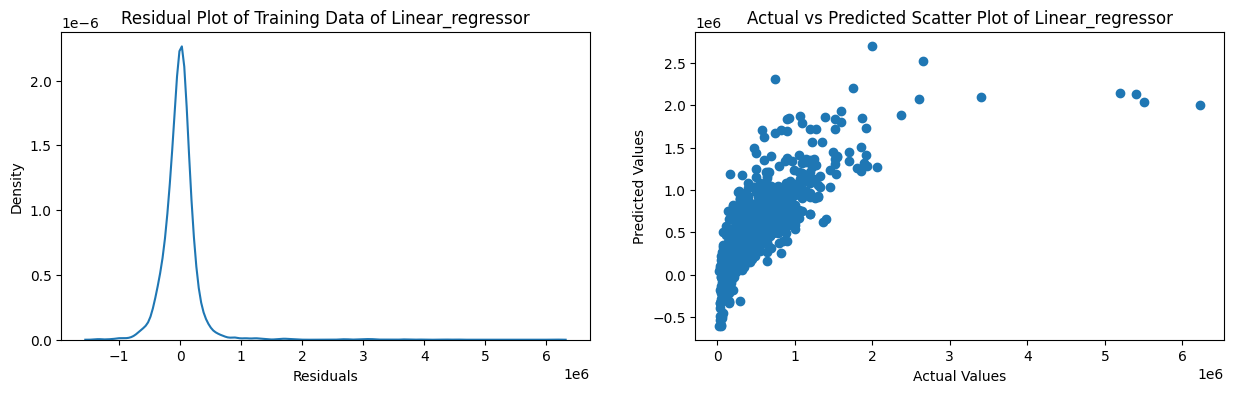

In [ ]:
# Defining a machine learning pipeline with two stages and Hyperparams
Lin_Reg_pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=True)
)
# Function to train, save and Evaluate the Linear Regression model
CarData_Model_All(Lin_Reg_pipeline, "Linear_regressor")

##### Random Forest Regressor

In [ ]:
# Intialize the Random Forest Regressors
Ranfor_Reg = RandomForestRegressor()

# Defining values for Hyperparameters

# Number of trees in Random forest
Num_Tress=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
Min_Split=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
Min_Leaf=[1,2,5,7]
# Number of fearures to be considered at each split
Max_feat=['auto','sqrt']

# Appending the values and Creating Hyperparameters Dictionary
Ranfor_For_Params = {"n_estimators":Num_Tress,
              "max_depth":max_depth,
              "min_samples_split":Min_Split,
              "min_samples_leaf":Min_Leaf,
              "max_features":Max_feat}

#Creating a RandomizedSearchCV object for hyperparameter tuning
Ranfor_Hyp_Reg = RandomizedSearchCV(estimator = Ranfor_Reg,
                           param_distributions = Ranfor_For_Params)

Training Data R-Squared score : 0.93
Testing Data R-Squared score : 0.88
Train Cross-Validation scores : [0.76780392 0.92571679 0.87911114 0.81093456 0.87918979]
Train Cross-Validation mean : 0.85


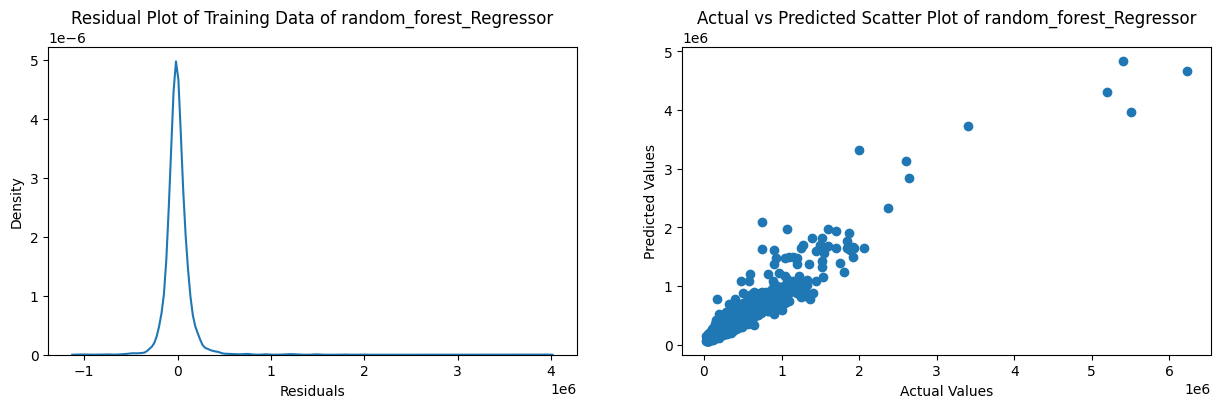

In [ ]:
# Function to train, save and Evaluate the Random Forest Regressor model
CarData_Model_All(Ranfor_Hyp_Reg,'random_forest_Regressor')

In [ ]:
#Print the best estimator after hyperparameter tuning.
print(Ranfor_Hyp_Reg.best_estimator_)

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=6, n_estimators=700)


##### Gradient Boosting Regressor

In [ ]:
# Intialize the Gradient Boosting Regressors
Grad_Boost_Reg = GradientBoostingRegressor()

# Defining values for Hyperparameters

# Rate at which correcting is being made
Lrn_rate = [0.001, 0.01, 0.1, 0.2]
# Number of trees in Gradient boosting
Estim_Val=list(range(500,1000,100))
# Maximum number of levels in a tree
max_depth=list(range(4,9,4))
# Minimum number of samples required to split an internal node
Min_Split_GB=list(range(4,9,2))
# Minimum number of samples required to be at a leaf node.
Min_Leaf_GB=[1,2,5,7]
# Number of fearures to be considered at each split
Max_Feat_GB=['auto','sqrt']

# Appending the values and Creating Hyperparameters Dictionary
GradBoost_Reg_Params = {"learning_rate":Lrn_rate,
              "n_estimators":Estim_Val,
              "max_depth":max_depth,
              "min_samples_split":Min_Split_GB,
              "min_samples_leaf":Min_Leaf_GB,
              "max_features":Max_Feat_GB}

#Creating a RandomizedSearchCV object for hyperparameter tuning
GradBoost_Hyp_Reg = RandomizedSearchCV(estimator = Grad_Boost_Reg,
                           param_distributions = GradBoost_Reg_Params)

Training Data R-Squared score : 0.99
Testing Data R-Squared score : 0.92
Train Cross-Validation scores : [0.91887279 0.93306529 0.9080771  0.84127255 0.90224422]
Train Cross-Validation mean : 0.9


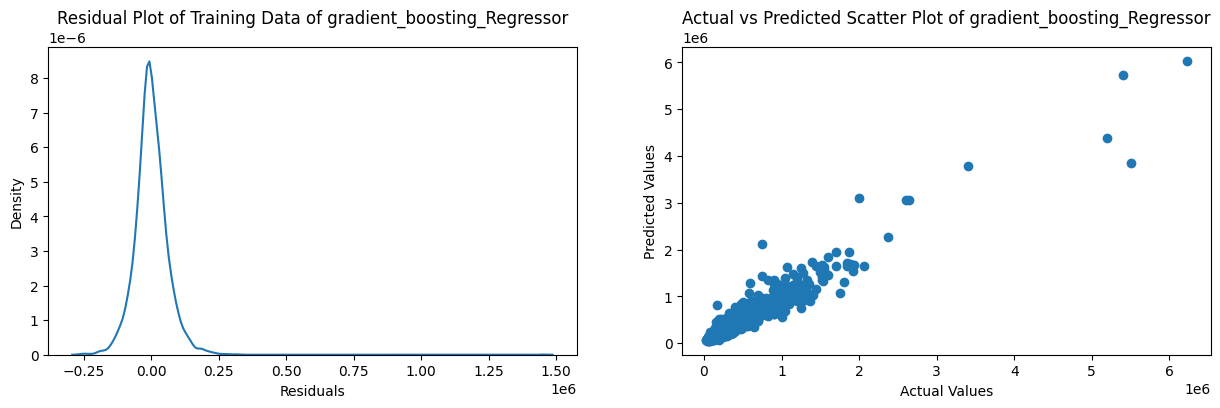

In [ ]:
# Function to train, save and Evaluate the Gradient Boosting Regressor model
CarData_Model_All(GradBoost_Hyp_Reg,"gradient_boosting_Regressor")

In [ ]:
#Print the best estimator after hyperparameter tuning.
print(GradBoost_Hyp_Reg.best_estimator_)

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_features='sqrt',
                          min_samples_split=4, n_estimators=700)


##### Ridge Regressor

Training Data R-Squared score : 0.64
Testing Data R-Squared score : 0.52
Train Cross-Validation scores : [0.60477175 0.70250637 0.63365679 0.61858278 0.59879307]
Train Cross-Validation mean : 0.63


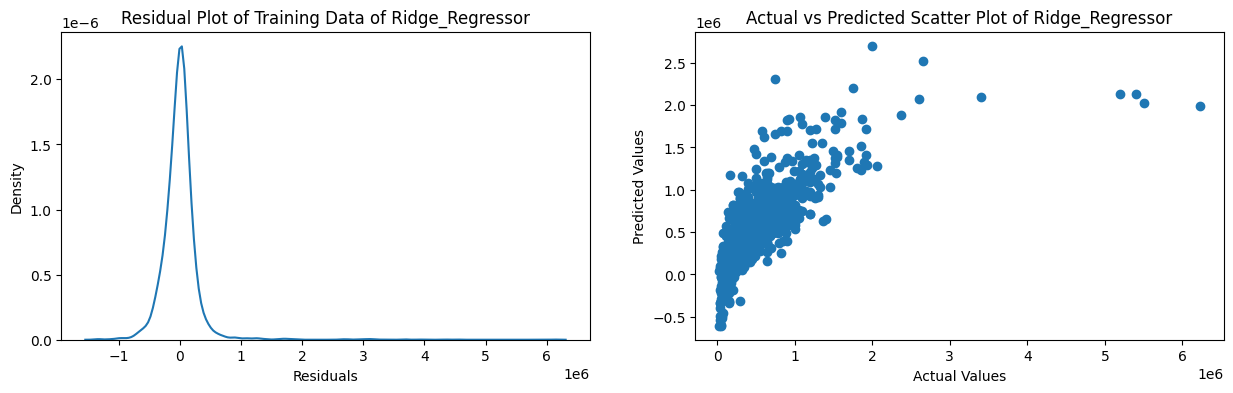

In [ ]:
# Creating Ridge regression model object
Ridge_Reg = Ridge()
# Defining a range of possible alpha values for hyperparameter tuning
alpha = np.logspace(-3,3,num=14)

#Creating a RandomizedSearchCV object for hyperparameter tuning
Ridge_Reg_Hyp = RandomizedSearchCV(estimator = Ridge_Reg, param_distributions = dict(alpha=alpha))

#Function to train, save and Evaluate the Ridge Regression model
CarData_Model_All(Ridge_Reg_Hyp,"Ridge_Regressor")

### Evaluation Of Models

In [ ]:
# List of models used for evaluation
Models_Used = ["Linear Regression","Random Forest Regressor","Gradient Boosting Regressor","Ridge Regression"]
#Creating a DataFrame to store performance metrics of each model
Cal_Val_Models=pd.DataFrame({'Model': Models_Used,'R Squared(Train)': R_Sqr_train,'R Squared(Test)': R_Sqr_test,'Cross validation score mean(Train)': Cross_Val})
# Displaying the DataFrame with model evaluation results
display(Cal_Val_Models)

,Model,R Squared(Train),R Squared(Test),Cross validation score mean(Train)
0,Linear Regression,0.64,0.52,0.63
1,Random Forest Regressor,0.93,0.88,0.85
2,Gradient Boosting Regressor,0.99,0.92,0.90
3,Ridge Regression,0.64,0.52,0.63
